In [1]:
import pandas as pd
import numpy as np
import torch as th
import paradime
import paradime.dr
import paradime.loss
import paradime.routines
import paradime.utils
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import torchvision
import json

C:\Users\isabe\miniconda3\envs\Bachelor\lib\site-packages\paradime\transforms.py:285: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _entropy(dists: np.ndarray, beta: float) -> float:


In [2]:
# Download Iris dataset
iris = datasets.load_iris()
iris_data = iris.data
iris_targets = iris.target

# Normalize the data
iris_data = iris_data / iris_data.max(axis=0)

# Convert data to PyTorch tensor
iris_data = th.tensor(iris_data, dtype=th.float32)
iris_targets = th.tensor(iris_targets, dtype=th.long)

def pca(x):
    return PCA(n_components=2).fit_transform(x)

derived = paradime.dr.DerivedData(pca)

th.manual_seed(0)
np.random.seed(0)

In [3]:
class twoNAMHybrid(th.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, output_dim=2, num_layers=1):
        super(twoNAMHybrid, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.submodules = th.nn.ModuleList()
        self.alpha = th.nn.Parameter(th.tensor(1.0))

        # Create the submodules for each input feature
        for i in range(input_dim):
            submodule = th.nn.Sequential()
            # Add layers to the submodule
            for l in range(num_layers):
                if l == 0:
                    submodule.add_module(f"linear_{l}", th.nn.Linear(1, hidden_dim))
                else:
                    submodule.add_module(f"linear_{l}", th.nn.Linear(hidden_dim, hidden_dim))
                submodule.add_module(f"ELU_{l}", th.nn.ELU())
                submodule.add_module(f"dropout_{l}", th.nn.Dropout(0.5))

            # Add the output layer
            submodule.add_module(f"linear_{num_layers}", th.nn.Linear(hidden_dim, hidden_dim))
            self.submodules.append(submodule)

        # Add the final layer
        self.emb_layer = th.nn.Linear(input_dim * hidden_dim, output_dim)
        self.class_layer = th.nn.Linear(input_dim * hidden_dim, num_classes)

    def common_forward(self, x):
        # Initialize a list to store the outputs of submodules
        output = []
        for i in range(self.input_dim):
            # Compute the output of the i-th submodule and append it to the list
            output.append(self.submodules[i](x[:, i].unsqueeze(1)).squeeze())
        # Concatenate the outputs along the first dimension
        output = th.cat(output, dim=1)
        return output

    def embed(self, x):
        x = self.common_forward(x)
        x = self.emb_layer(x)
        return x

    def classify(self, x):
        x = self.common_forward(x)
        x = self.class_layer(x)
        return x

In [4]:
global_rel = paradime.relations.NeighborBasedPDist(
    transform=[
        paradime.transforms.PerplexityBasedRescale(
            perplexity=30, bracket=[0.001, 1000]
        ),
        paradime.transforms.Symmetrize(),
        paradime.transforms.Normalize(),
    ]
)
batch_rel = paradime.relations.DifferentiablePDist(
    transform=[
        paradime.transforms.StudentTTransform(alpha=1.0),
        paradime.transforms.Normalize(),
        paradime.transforms.ToSquareTensor(),
    ]
)

embeddings = []
losses = {
    "init": paradime.loss.PositionLoss(position_key="pca"),
    "embedding": paradime.loss.RelationLoss(
        loss_function=paradime.loss.kullback_leibler_div
    ),
}

tsne_init = paradime.dr.TrainingPhase(
    name="pca_init",
    loss_keys=["init"],
    batch_size=500,
    epochs=10,
    learning_rate=0.01,
)

tsne_main = paradime.dr.TrainingPhase(
    name="embedding",
    loss_keys=["embedding"],
    batch_size=500,
    epochs=40,
    learning_rate=0.02,
    report_interval=2,
)

In [5]:
hybrid_tsne = paradime.dr.ParametricDR(
    model=twoNAMHybrid(
        input_dim=2, hidden_dim=100, num_classes=10, output_dim=2,
    ),
    global_relations=global_rel,
    batch_relations=batch_rel,
    derived_data={"pca": derived},
    losses=losses,
    use_cuda=True,
    verbose=True,
)
hybrid_tsne.add_training_phase(tsne_init)
hybrid_tsne.add_training_phase(tsne_main)

hybrid_tsne.train({
    "main": iris_data,
    "labels": iris_targets,
})

embeddings.append(hybrid_tsne.apply(iris_data, "embed"))

2023-06-25 16:53:30,860: Initializing training dataset.
2023-06-25 16:53:30,861: Computing derived data entry 'pca'.
2023-06-25 16:53:30,867: Adding entry 'pca' to dataset.
2023-06-25 16:53:30,868: Computing global relations 'rel'.
2023-06-25 16:53:30,868: Indexing nearest neighbors.
2023-06-25 16:53:52,125: Calculating probabilities.
2023-06-25 16:53:52,556: Beginning training phase 'pca_init'.
2023-06-25 16:53:54,614: Loss after epoch 0: 0.15653346478939056
2023-06-25 16:53:54,643: Loss after epoch 5: 0.2715376317501068
2023-06-25 16:53:54,680: Beginning training phase 'embedding'.
2023-06-25 16:53:54,714: Loss after epoch 0: 0.010108435526490211
2023-06-25 16:53:54,764: Loss after epoch 2: 0.010108286514878273
2023-06-25 16:53:54,815: Loss after epoch 4: 0.009791013784706593
2023-06-25 16:53:54,829: Loss after epoch 6: 0.009045909158885479
2023-06-25 16:53:54,844: Loss after epoch 8: 0.00772784324362874
2023-06-25 16:53:54,859: Loss after epoch 10: 0.007212176453322172
2023-06-25 16

Text(0.5, 1.0, 't-SNE visualization of Iris dataset')

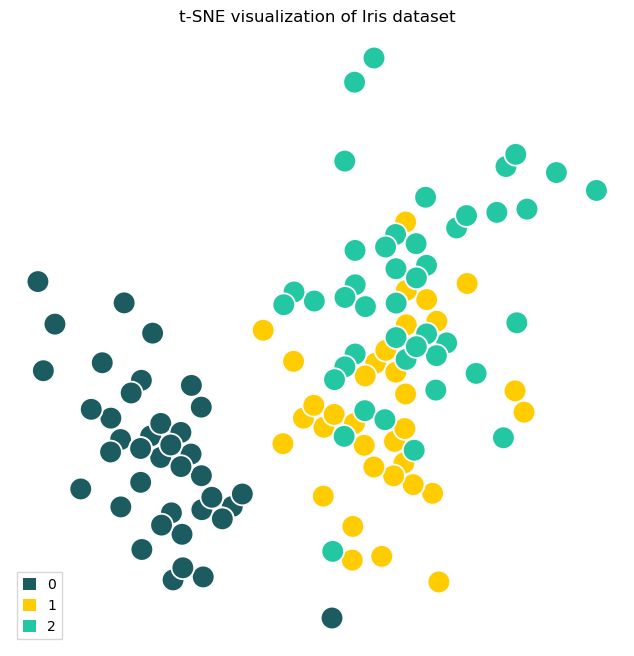

In [6]:
# Create a figure
fig = plt.figure(figsize=(8, 8))

# Create a scatter plot for the embedding
ax = fig.add_subplot(1, 1, 1)
    
# Use Paradime's scatterplot utility to plot the embedding with class labels as colors
paradime.utils.plotting.scatterplot(
    embeddings[0],
    labels=iris_targets,
    ax=ax,
    legend=True,
    legend_options={"loc": 3},
)
ax.set_title("t-SNE visualization of Iris dataset") 

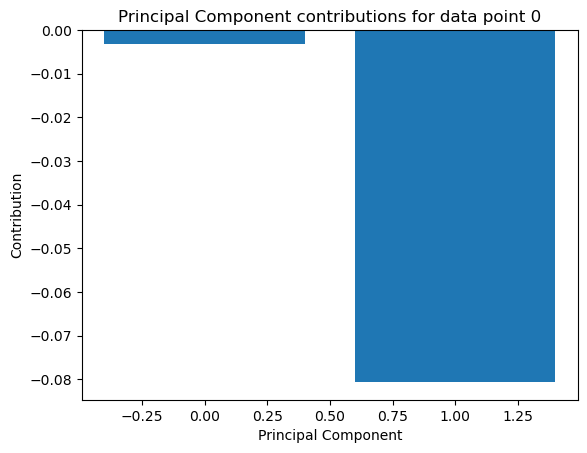

In [9]:
# Select a data point
idx = 0
data_point = iris_data[idx]

# Ensure the data point has the correct dimensions
if len(data_point.shape) == 1:
    data_point = data_point.view(1, -1)

# Move the data to the GPU
data_point = data_point.to('cuda')

# Get the output of each submodule and compute the mean
output = []
for i, submodule in enumerate(hybrid_tsne.model.submodules):
    submodule_output = submodule(data_point[:, i].unsqueeze(1))
    # Ensure the output is a 2D tensor
    if len(submodule_output.shape) == 1:
        submodule_output = submodule_output.view(1, -1)
    # Compute the mean of the output vector
    mean_contribution = th.mean(submodule_output)
    output.append(mean_contribution)

# Convert the list to a tensor
output = th.stack(output)

# Move the output back to the CPU for plotting
output = output.to('cpu')

# Create a figure
fig, ax = plt.subplots()

# Plot the outputs of the submodules
ax.bar(range(hybrid_tsne.model.input_dim), output.detach().numpy())

# Set the title and labels
ax.set_title('Principal Component contributions for data point {}'.format(idx))
ax.set_xlabel('Principal Component')
ax.set_ylabel('Contribution')

# Show the plot
plt.show()